In [1]:
import torch, json
from math import floor
import pandas as pd
import numpy as np

from FileManager.dataManager import dataManager
from AnalyzeTools.models import autoregressive_integrated_moving_average, linear_regression, support_vector_regression, random_forest, gradient_boosting
from AnalyzeTools.prepare import data_split, model_eval, pathForSavingModels
from AnalyzeTools.preprocess import preprocessData, removeOutliers, createPeriodData
from AnalyzeTools.superModels import DEEPAR, TFT, RNN

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 123


In [2]:
period = 'Day'
predict_type = 'single'
future_step = 1
test_size = 0.2
params_path = f'./Models'

product_object = json.load(open("./File information.json", "r", encoding='utf8'))

all_experiments= []
for product in product_object.keys():
    for raw_file_name in  product_object[product].keys():
        for product_type in product_object[product][raw_file_name]['product_types']:
            for target in product_object[product][raw_file_name]['targets']:
                all_experiments.append([product, raw_file_name, product_type, target])

In [4]:
n = 15
experiment = all_experiments[n]
product, raw_file_name, product_type, target = experiment
print(f"Product: {product}\nRaw file name: {raw_file_name}\nProduct_type: {product_type}\ntarget: {target}")



Product: beef
Raw file name: 축산유통정보 - 소비자가격
Product_type: 4401
target: DLPC


In [12]:
df, product_and_product_type, product_attribute = dataManager(raw_file_name, product, product_type, target)
if len(df) == 0:
    raise ValueError("No data!")
    
df = createPeriodData(df, {'date': 'first', 'others': 'mean'}, period, 'date')

In [ ]:
ml_searchCV_params = {
    'base_dir': params_path,
    'product_and_product_type': product_and_product_type,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'predict_type': 'single',
    'period': period,
    'step': future_step,
    'save': True
}
stdout = True
vis = True

There are too few features in the data. The raw data features will be used.
Too few features to filter!

-->Final features:
  []
Number of outliers detected: -19
Number of normal samples detected: 605


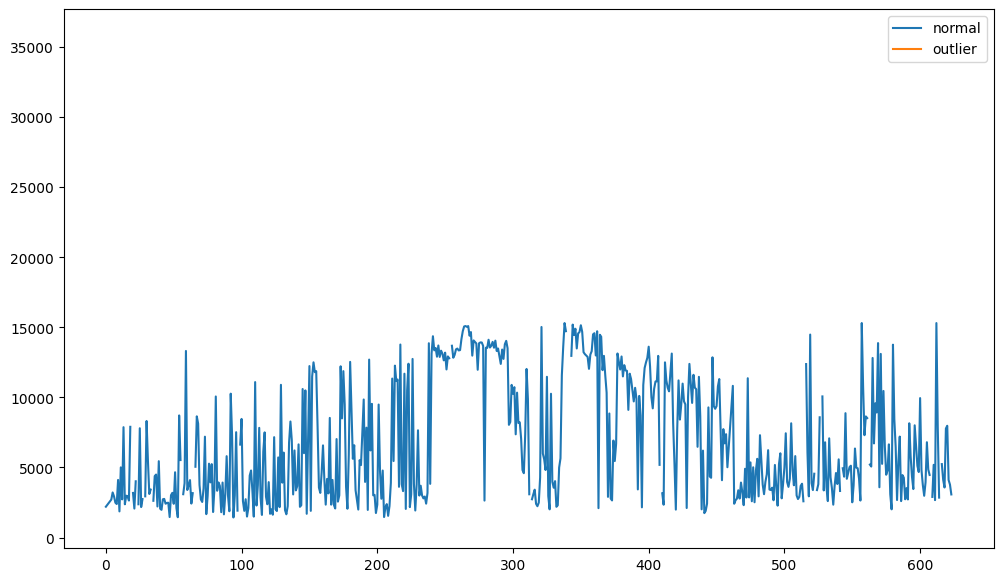

In [13]:
df, input_features = preprocessData(df, 'date', target, period)

df = removeOutliers(df, test_size, target)

train_x_axis = df['date'][:-1*floor(len(df) * test_size)].values if type(test_size) == float else df['date'][:-1*test_size]
predictions_x_axis = df['date'][-1*floor(len(df) * test_size):].values if type(test_size) == float else df['date'][-1*test_size:]

In [7]:
# prepare dataset for statistics and Macnhine models
ml_split_params = {'Model': 'ML', 'Future': future_step}
X_train, X_test, y_train, y_test, input_scaler, output_scaler = data_split(df, input_features, target, test_size, scaling=True, **ml_split_params)

X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)
x_axis = np.append(train_x_axis, predictions_x_axis, axis=0)

ml_searchCV_params = {
    'base_dir': params_path,
    'product_and_product_type': product_and_product_type,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'predict_type': predict_type,
    'period': period,
    'step': future_step,
    'save': True
}

X_train: (919, 3) y_train: (919,) X_test: (230, 3) y_test: (230,)


# Statistics

In [8]:
print("\nARIMA")
arima_predictions = autoregressive_integrated_moving_average(y_train, y_test)
model_eval(y_test, arima_predictions, predictions_x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})


ARIMA
MAPE: 0.00432117293141933 R square: 0.9752495998872424


In [9]:
print("\nLinear Regression")
lr, _ = linear_regression(X_train, y_train)
lr_predictions = lr.predict(X_test)
model_eval(y_test, lr_predictions, predictions_x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})


Linear Regression
MAPE: 0.004123211057335885 R square: 0.9757184752664138


# Machine learning

In [10]:
print("\nSupport Vector Regression")
svr, _ = support_vector_regression(X_train, y_train, search=True, **ml_searchCV_params)
svr_predictions = svr.predict(X_test)
model_eval(y_test, svr_predictions, predictions_x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})


Support Vector Regression
--> Use the existed best parameters!

Best parameter for SVR is:
  {'C': 100, 'gamma': 0.001, 'epsilon': 0.01, 'kernel': 'rbf'}
MAPE: 0.004973264678612196 R square: 0.9749165108863451


In [11]:
print("\nRandom Forest")
rf, _ = random_forest(X_train, y_train, search=True, **ml_searchCV_params)
rf_predictions = rf.predict(X_test)
model_eval(y_test, rf_predictions, predictions_x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})


Random Forest
--> Use the existed best parameters!

Best parameter for Random forest is:
  {'n_estimators': 190, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
MAPE: 0.014497425611355207 R square: 0.87342367361898


In [12]:
print("\nGradient Boosting")
gb, _ = gradient_boosting(X_train, y_train, search=True, **ml_searchCV_params)
# gb_predictions = gb.predict(X)
gb_predictions = gb.predict(X_test)
model_eval(y_test, gb_predictions, predictions_x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})
# model_eval(y, gb_predictions, x_axis, stdout=stdout, vis=vis, **{'scaler': output_scaler})


Gradient Boosting
--> Use the existed best parameters!

Best parameter for Gradient Boosting is:
  {'n_estimators': 70, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
MAPE: 0.016515766615858966 R square: 0.8542670462954873


# Deep learning

In [13]:
data = df.copy()

data['time_idx'] = range(len(data))
data['group'] = product

training_cutoff = floor(len(data) * (1-test_size)) if type(test_size) == float else len(data) - test_size

max_prediction_length = 1 # In the case of point forecasting, this parameter is 1 by default
if period == 'Day':
    max_encoder_length = 30 # 7, 14, 30, 60, 120
    batch_size = 64
elif period == 'Week':
    max_encoder_length = 15
    batch_size = 32
elif period == 'Month':
    max_encoder_length = 3
    batch_size = 8

group = ['group']
time_varying_known_categoricals = ['month', 'week']
time_varying_unknown_categoricals = []
time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = input_features + [target]

In [14]:
dl_searchCV_params = {
    'base_dir': params_path,
    'product_and_product_type': product_and_product_type,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'predict_type': 'single',
    'period': period,
    'step': future_step,
    'save': True
}

In [15]:
print("\nLSTM")
training_params = {'max_epochs': 50, 'n_trials': 10}
saving_dir = pathForSavingModels('LSTM', **dl_searchCV_params)
lstm, val_dataloader = RNN(
    data,
    training_cutoff,
    target,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    saving_dir,
    'LSTM',
    training_params,
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
lstm_predictions = lstm.predict(val_dataloader)
model_eval(actuals, lstm_predictions, predictions_x_axis, stdout=True, vis=True)


LSTM
MAPE: 0.009010511450469494 R square: 0.9587410297703218


In [16]:
print("\nGRU")
training_params = {'max_epochs': 20, 'n_trials': 10}
saving_dir = pathForSavingModels('GRU', **dl_searchCV_params)
gru, val_dataloader = RNN(
    data,
    training_cutoff,
    target,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    saving_dir,
    'GRU',
    training_params
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
gru_predictions = gru.predict(val_dataloader)

model_eval(actuals, gru_predictions, predictions_x_axis, stdout=True, vis=True)


GRU
MAPE: 0.007110469974577427 R square: 0.9678722161512188


In [17]:
print("\nDeepAR")
training_params = {'max_epochs': 20, 'n_trials': 10}
saving_dir = pathForSavingModels('DeepAR', **dl_searchCV_params)
deep_ar, val_dataloader = DEEPAR(
    data,
    training_cutoff,
    target,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    saving_dir,
    training_params
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
deepar_predictions = deep_ar.predict(val_dataloader)

model_eval(actuals, deepar_predictions, predictions_x_axis, stdout=True, vis=True)


DeepAR
MAPE: 0.044349074363708496 R square: 0.33655573066124844


# Transformer

In [18]:
print("\nTFT")
training_params = {
    'max_epochs': 20, 
    'n_trials': 5, 
    'output_size': 1, 
    'hidden_size_range': (8, 128), 
    'hidden_continuous_size_range': (8, 16),
    'attention_head_size_range': (1, 2) 
}
saving_dir = pathForSavingModels('TFT', **dl_searchCV_params)
tft, val_dataloader = TFT(
    data,
    training_cutoff,
    target,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_unknown_categoricals,
    time_varying_known_categoricals,
    time_varying_known_reals,
    time_varying_unknown_reals,
    batch_size,
    saving_dir,
    'single',
    **training_params
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
tft_predictions = tft.predict(val_dataloader)

model_eval(actuals, tft_predictions, predictions_x_axis, stdout=True, vis=True)


TFT
MAPE: 0.005600895266979933 R square: 0.9716189284924147
